In [25]:
import numpy as np
import tensorflow as tf
from neurophox.tensorflow  import RM, TM, BM
import matplotlib.pyplot as plt
from neurophox.numpy import *

In [26]:
def fidelity(A, B):
    """
    Calculate the fidelity between two matrices A and B.
    Fidelity is defined as: |Tr(A^† B)|^2 / (Tr(A^† A) * Tr(B^† B))

    Args:
        A (np.ndarray): First matrix
        B (np.ndarray): Second matrix

    Returns:
        float: Fidelity value between 0 and 1
    """
    numerator = np.abs(np.trace(A.conj().T @ B))**2
    denominator = np.trace(A.conj().T @ A) * np.trace(B.conj().T @ B)
    return np.real(numerator / denominator)

In [27]:
n = 3
rec_mesh = RM(n, basis="sm")
tri_mesh = TM(n, basis="sm")
but_mesh = BM(n, basis="sm")
print(but_mesh.matrix.shape)

(8, 8)


c:\Users\varuntaidixit\Anaconda3\envs\neurophox-env\lib\site-packages\neurophox\helpers.py:186: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  [np.hstack([i, i + frequency] for i in range(frequency)) + 2 * frequency * split_num


Running for n = 4...


Running for n = 8...
Running for n = 16...
Running for n = 32...


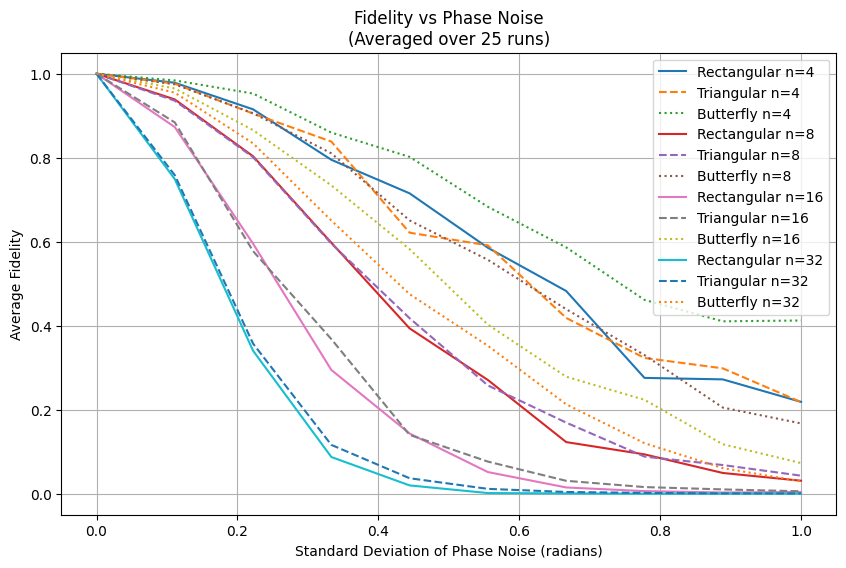

In [28]:
n_list = [4, 8, 16, 32]  # Matrix sizes to sweep
stdvs = np.linspace(0, 1, 10)
n_avg = 25  # Number of averages per stddev

# Storage: for each size, save fidelity curves
rec_fidelity_curves = {}
tri_fidelity_curves = {}
but_fidelity_curves = {}

for n in n_list:
    print(f"Running for n = {n}...")
    # Create meshes
    rec_mesh = RM(n)
    tri_mesh = TM(n)
    but_mesh = BM(int(np.log2(n)))

    # Save original matrices and phases
    og_matrix = rec_mesh.matrix
    og_theta = rec_mesh.theta.numpy()
    og_phi = rec_mesh.phi.numpy()

    og_tri_matrix = tri_mesh.matrix
    og_tri_theta = tri_mesh.theta.numpy()
    og_tri_phi = tri_mesh.phi.numpy()
    
    og_but_matrix = but_mesh.matrix
    og_but_theta = but_mesh.theta.numpy()
    og_but_phi = but_mesh.phi.numpy()

    rec_fidelities = []
    tri_fidelities = []
    but_fidelities = []

    for std in stdvs:
        rec_fid_samples = []
        tri_fid_samples = []
        but_fid_samples = []

        for _ in range(n_avg):
            # Rectangular mesh perturbation
            new_theta = og_theta + np.random.normal(loc=0.0, scale=std, size=og_theta.shape)
            new_phi = og_phi + np.random.normal(loc=0.0, scale=std, size=og_phi.shape)
            rec_mesh.theta.assign(tf.convert_to_tensor(new_theta, dtype=tf.float32))
            rec_mesh.phi.assign(tf.convert_to_tensor(new_phi, dtype=tf.float32))
            rec_fid_samples.append(fidelity(og_matrix, rec_mesh.matrix))

            # Triangular mesh perturbation
            new_tri_theta = og_tri_theta + np.random.normal(loc=0.0, scale=std, size=og_tri_theta.shape)
            new_tri_phi = og_tri_phi + np.random.normal(loc=0.0, scale=std, size=og_tri_phi.shape)
            tri_mesh.theta.assign(tf.convert_to_tensor(new_tri_theta, dtype=tf.float32))
            tri_mesh.phi.assign(tf.convert_to_tensor(new_tri_phi, dtype=tf.float32))
            tri_fid_samples.append(fidelity(og_tri_matrix, tri_mesh.matrix))

            # Butterfly
            new_but_theta = og_but_theta + np.random.normal(0.0, std, og_but_theta.shape)
            new_but_phi = og_but_phi + np.random.normal(0.0, std, og_but_phi.shape)
            but_mesh.theta.assign(tf.convert_to_tensor(new_but_theta, dtype=tf.float32))
            but_mesh.phi.assign(tf.convert_to_tensor(new_but_phi, dtype=tf.float32))
            but_fid_samples.append(fidelity(og_but_matrix, but_mesh.matrix))
        
        # Average fidelities at this std
        rec_fidelities.append(np.mean(rec_fid_samples))
        tri_fidelities.append(np.mean(tri_fid_samples))
        but_fidelities.append(np.mean(but_fid_samples))

    # Save the fidelity curves
    rec_fidelity_curves[n] = rec_fidelities
    tri_fidelity_curves[n] = tri_fidelities
    but_fidelity_curves[n] = but_fidelities

# Plot
plt.figure(figsize=(10,6))

for n in n_list:
    plt.plot(stdvs, rec_fidelity_curves[n], label=f"Rectangular n={n}", linestyle='-')
    plt.plot(stdvs, tri_fidelity_curves[n], label=f"Triangular n={n}", linestyle='--')
    plt.plot(stdvs, but_fidelity_curves[n], label=f"Butterfly n={n}", linestyle=':')


plt.xlabel("Standard Deviation of Phase Noise (radians)")
plt.ylabel("Average Fidelity")
plt.title(f"Fidelity vs Phase Noise\n(Averaged over {n_avg} runs)")
plt.grid(True)
plt.legend()
plt.show()

In [29]:
from neurophox.ml.nonlinearities import cnorm, cnormsq
n = 64
mesh = RM(n, basis="sm")
rm_model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(n,)),
    tf.keras.layers.Lambda(lambda x: tf.complex(x, tf.zeros_like(x))),
    mesh,
    # tf.keras.layers.Activation(cnormsq),
    tf.keras.layers.Lambda(lambda x: tf.math.abs(x[:, :10])), # get first 2 output ports,
    tf.keras.layers.Activation('softmax')
])

rm_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0025),
    metrics=['accuracy']
)

In [30]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [31]:
og_y_train = y_train
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# 3. Expand dims to (batch_size, 28, 28, 1) for pooling
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

# 4. Average Pooling: 28x28 → 9x9
x_train = tf.nn.avg_pool2d(x_train, ksize=3, strides=3, padding='VALID')
x_test = tf.nn.avg_pool2d(x_test, ksize=3, strides=3, padding='VALID')

# 5. Crop to 8x8
x_train = x_train[:, :8, :8, :]  # (60000, 8, 8, 1)
x_test = x_test[:, :8, :8, :]

# 6. Squeeze channel and Flatten
x_train = tf.squeeze(x_train, axis=-1)  # (60000, 8, 8)
x_test = tf.squeeze(x_test, axis=-1)

x_train = tf.reshape(x_train, (-1, 64))  # (60000, 64)
x_test = tf.reshape(x_test, (-1, 64))    # (10000, 64)

print(y_test)


tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10000, 10), dtype=float32)


In [32]:

history = rm_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/5
1688/1688 [==============================] - 31s 13ms/step - loss: 1.7961 - accuracy: 0.6990 - val_loss: 1.6547 - val_accuracy: 0.8048
Epoch 2/5
1688/1688 [==============================] - 21s 12ms/step - loss: 1.6716 - accuracy: 0.7673 - val_loss: 1.6244 - val_accuracy: 0.8187
Epoch 3/5
1688/1688 [==============================] - 21s 12ms/step - loss: 1.6553 - accuracy: 0.7736 - val_loss: 1.6167 - val_accuracy: 0.8073
Epoch 4/5
1688/1688 [==============================] - 22s 13ms/step - loss: 1.6490 - accuracy: 0.7759 - val_loss: 1.6104 - val_accuracy: 0.8177
Epoch 5/5
1688/1688 [==============================] - 23s 13ms/step - loss: 1.6454 - accuracy: 0.7754 - val_loss: 1.6058 - val_accuracy: 0.8245


In [33]:
test_loss, test_acc = rm_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.6260 - accuracy: 0.7971
Test accuracy: 0.7971


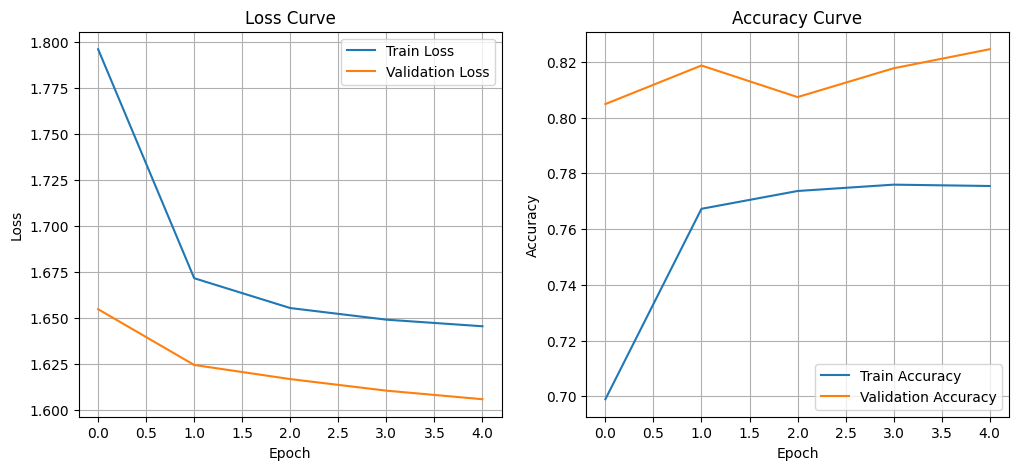

In [34]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


(64,)
9
4
6
2


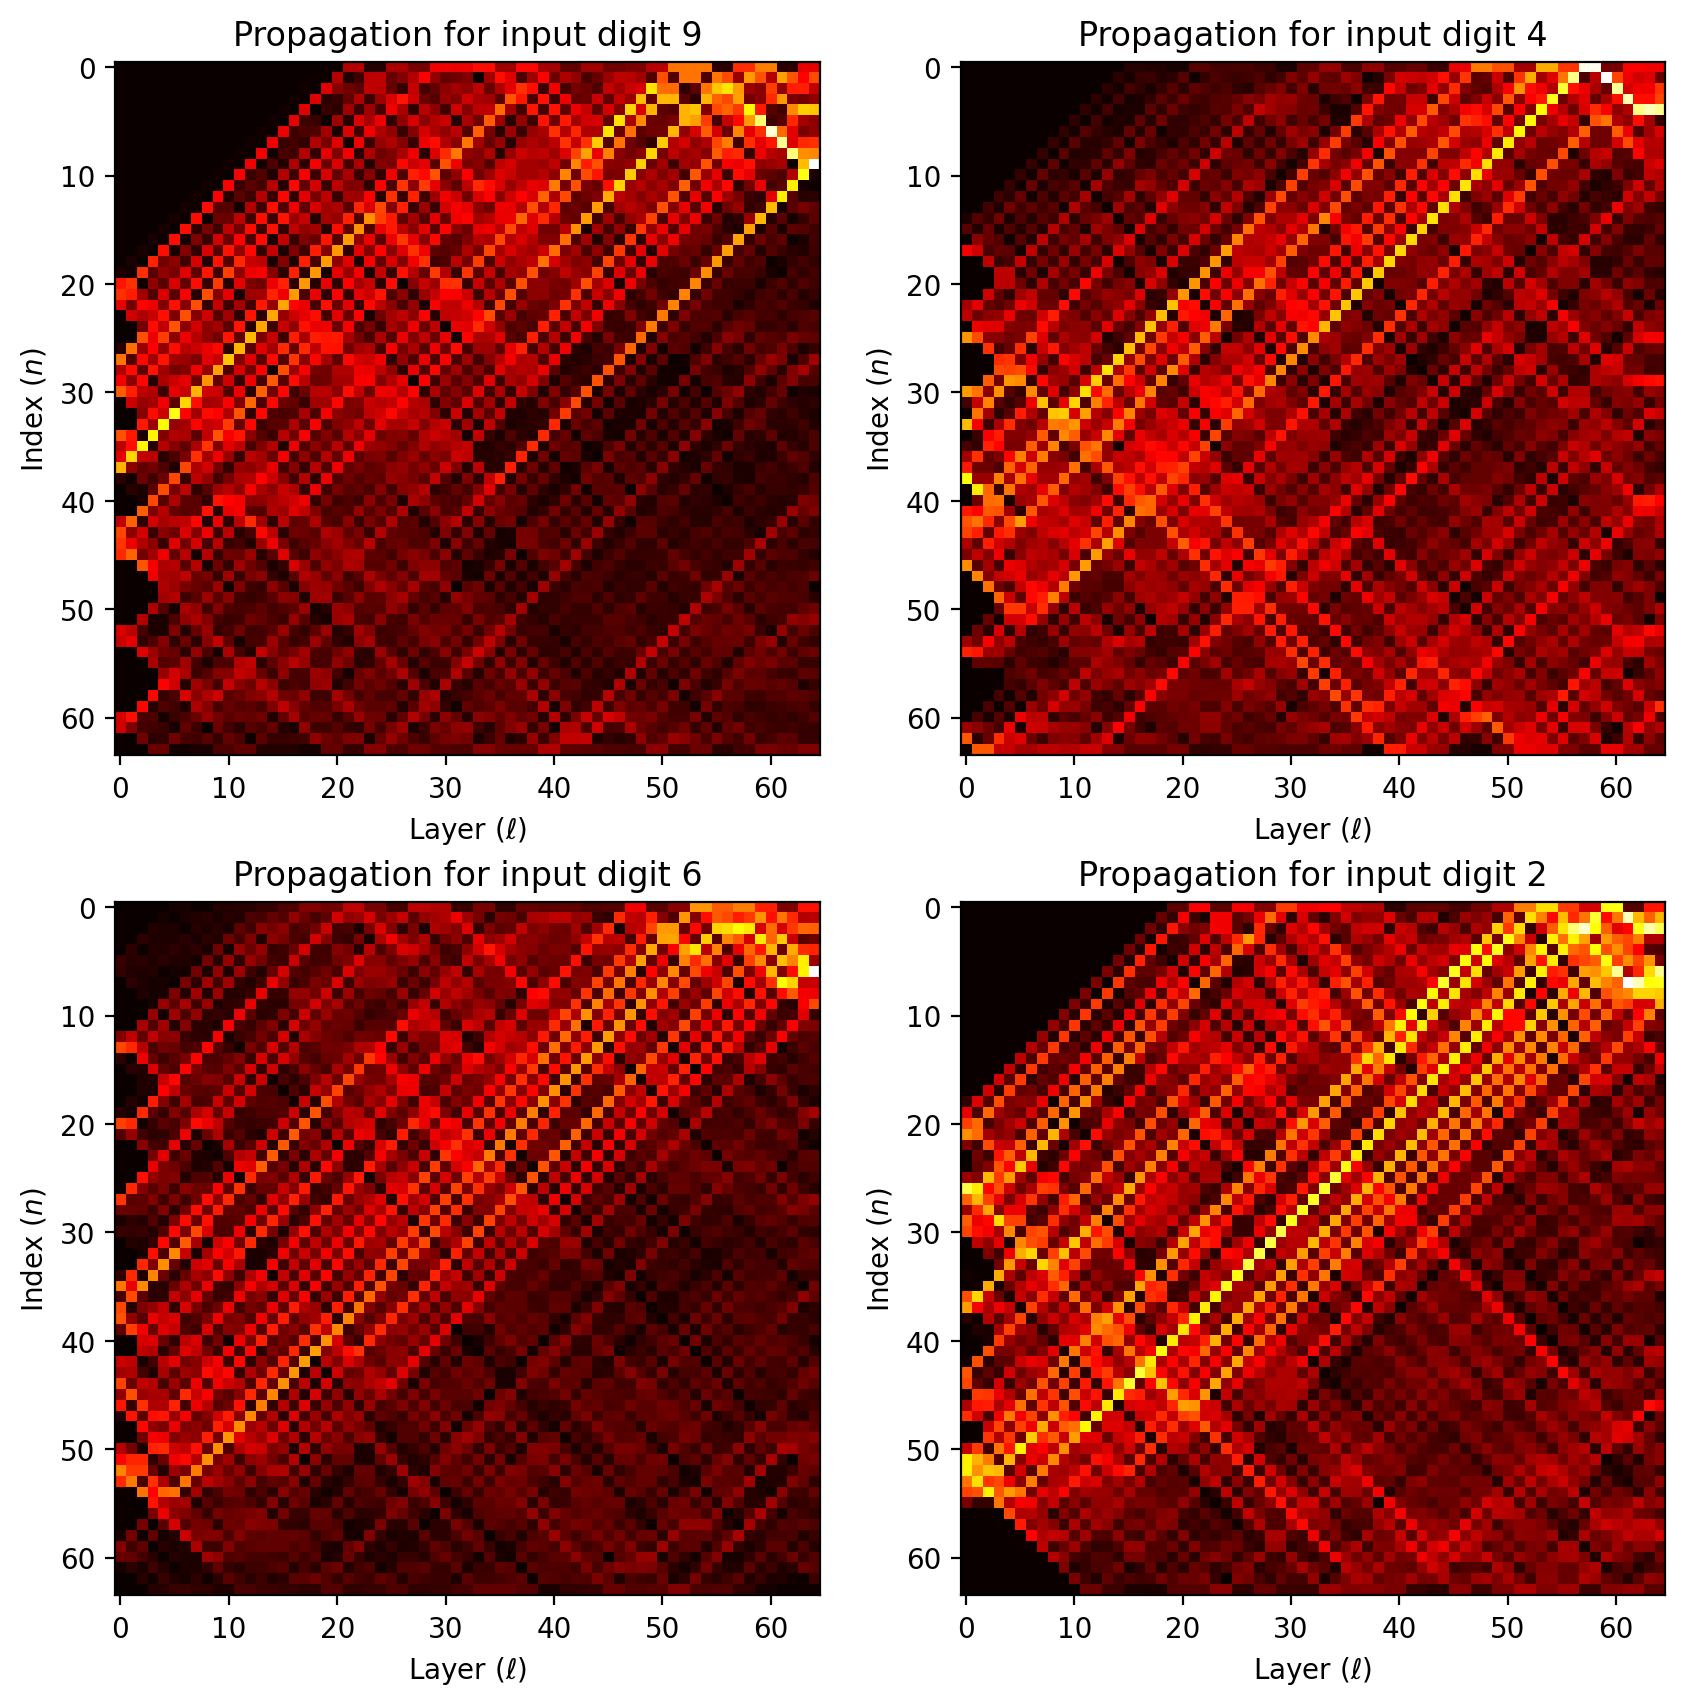

In [35]:
np_layer = RMNumpy(n, phases=mesh.phases, basis="sm")

nn=4
plt.figure(dpi=200, figsize=(10, 10))
plt.subplot(221)
inp = x_train[nn].numpy()
print(inp.shape)
plt.imshow(np.abs(np_layer.propagate(inp).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title(f'Propagation for input digit {og_y_train[nn]}')
print(og_y_train[nn])

nn=2
inp = x_train[nn].numpy()
plt.subplot(222)
plt.imshow(np.abs(np_layer.propagate(inp).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title(f'Propagation for input digit {og_y_train[nn]}')
print(og_y_train[nn])

nn=13
inp = x_train[nn].numpy()
plt.subplot(223)
plt.imshow(np.abs(np_layer.propagate(inp).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title(f'Propagation for input digit {og_y_train[nn]}')
print(og_y_train[nn])

nn=143
inp = x_train[nn].numpy()
plt.subplot(224)
plt.imshow(np.abs(np_layer.propagate(inp).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title(f'Propagation for input digit {og_y_train[nn]}')
print(og_y_train[nn])

In [36]:
og_matrix = mesh.matrix
og_theta = mesh.theta.numpy()
og_phi = mesh.phi.numpy()

4
4
4
4


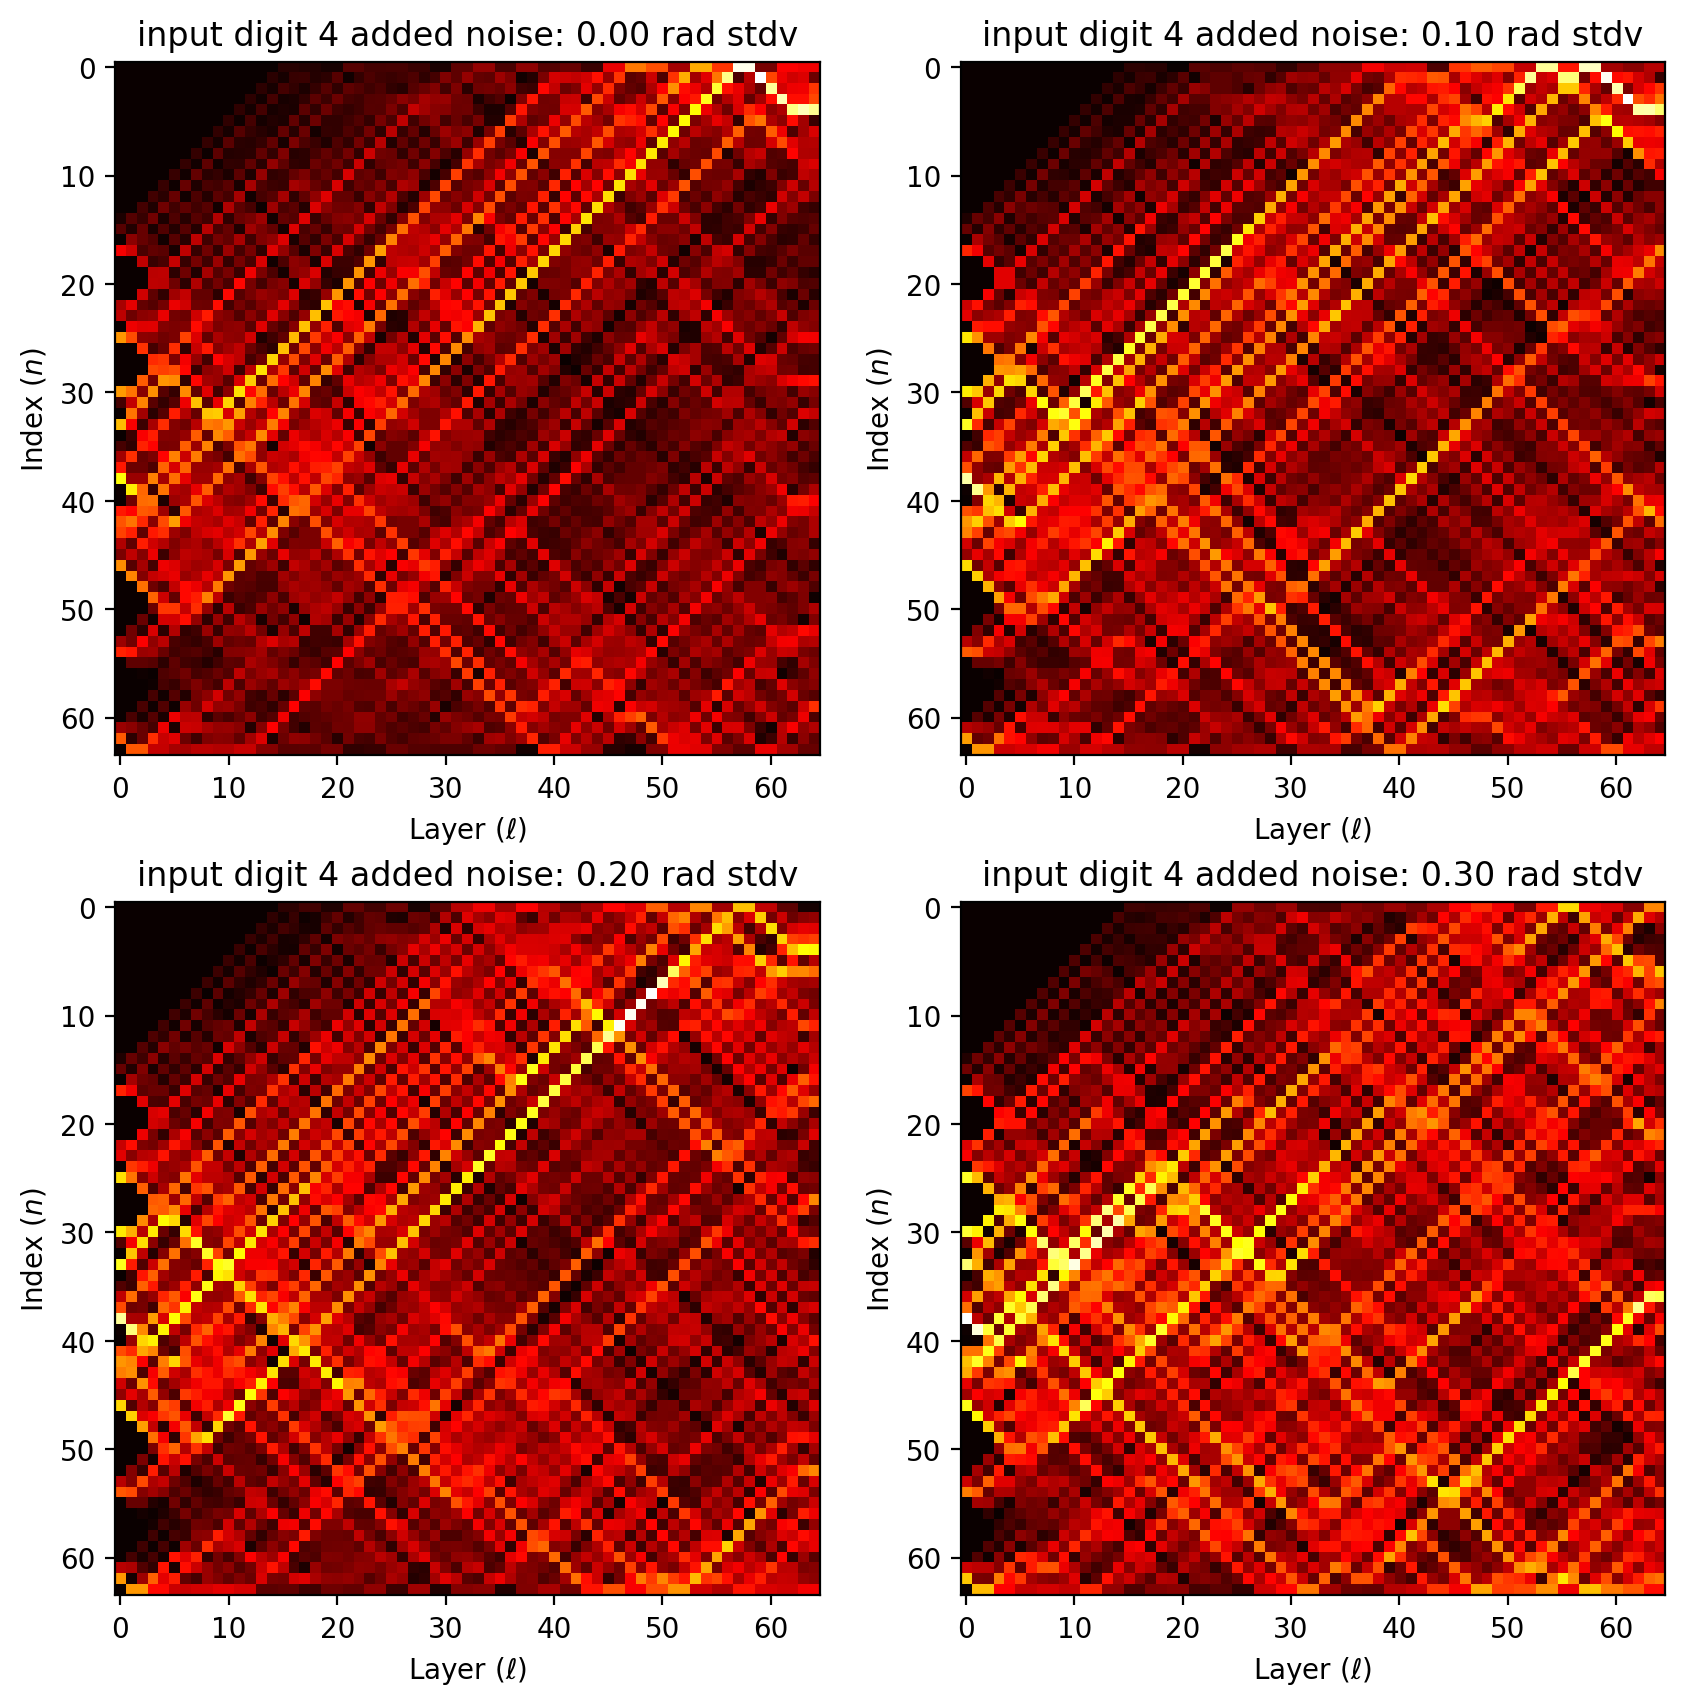

In [47]:
stdvs = np.linspace(0, .3, 4)
nn=2
n_avg = 1

idx = 1
plt.figure(dpi=200, figsize=(10, 10))
for std in stdvs:
    for i in range(n_avg):
        # Rectangular mesh perturbation
        new_theta = og_theta + np.random.normal(loc=0.0, scale=std, size=og_theta.shape)
        new_phi = og_phi + np.random.normal(loc=0.0, scale=std, size=og_phi.shape)
        mesh.theta.assign(tf.convert_to_tensor(new_theta, dtype=tf.float32))
        mesh.phi.assign(tf.convert_to_tensor(new_phi, dtype=tf.float32))
        
        np_layer = RMNumpy(n, phases=mesh.phases, basis="sm")
        inp = x_train[nn].numpy()
        plt.subplot(220+idx)
        idx += 1
        plt.imshow(np.abs(np_layer.propagate(inp).squeeze()).T, cmap='hot')
        plt.ylabel("Index ($n$)")
        plt.xlabel("Layer ($\ell$)")
        plt.title(f'input digit {og_y_train[nn]} added noise: {std:.2f} rad stdv', )
        print(og_y_train[nn])
 

In [38]:
stdvs = np.linspace(0, .3, 4)
nn=2
n_avg = 5
losses = []
accs = []
fids = []

idx = 1
plt.figure(dpi=200, figsize=(10, 10))
for std in stdvs:
    lossum = 0
    accsum = 0
    fidsum = 0
    for i in range(n_avg):
        # Rectangular mesh perturbation
        new_theta = og_theta + np.random.normal(loc=0.0, scale=std, size=og_theta.shape)
        new_phi = og_phi + np.random.normal(loc=0.0, scale=std, size=og_phi.shape)
        mesh.theta.assign(tf.convert_to_tensor(new_theta, dtype=tf.float32))
        mesh.phi.assign(tf.convert_to_tensor(new_phi, dtype=tf.float32))
        
        fidsum += fidelity(og_matrix, mesh.matrix)
        
        test_loss, test_acc = rm_model.evaluate(x_test, y_test)
        print(f"Test accuracy: {test_acc:.4f}")
        lossum += test_loss
        accsum += test_acc
    losses.append(lossum/n_avg)
    accs.append(accsum/n_avg)
    fids.append(fidsum/n_avg)

313/313 [==============================] - 1s 3ms/step - loss: 1.6260 - accuracy: 0.7971
Test accuracy: 0.7971
313/313 [==============================] - 1s 3ms/step - loss: 1.6260 - accuracy: 0.7971
Test accuracy: 0.7971
313/313 [==============================] - 1s 3ms/step - loss: 1.6260 - accuracy: 0.7971
Test accuracy: 0.7971
313/313 [==============================] - 1s 3ms/step - loss: 1.6260 - accuracy: 0.7971
Test accuracy: 0.7971
313/313 [==============================] - 1s 3ms/step - loss: 1.6260 - accuracy: 0.7971
Test accuracy: 0.7971
313/313 [==============================] - 1s 3ms/step - loss: 1.8714 - accuracy: 0.5581
Test accuracy: 0.5581
313/313 [==============================] - 1s 3ms/step - loss: 1.8968 - accuracy: 0.6180
Test accuracy: 0.6180
313/313 [==============================] - 1s 3ms/step - loss: 1.8331 - accuracy: 0.6661
Test accuracy: 0.6661
313/313 [==============================] - 1s 3ms/step - loss: 1.8845 - accuracy: 0.6395
Test accuracy: 0.6395
3

<Figure size 2000x2000 with 0 Axes>

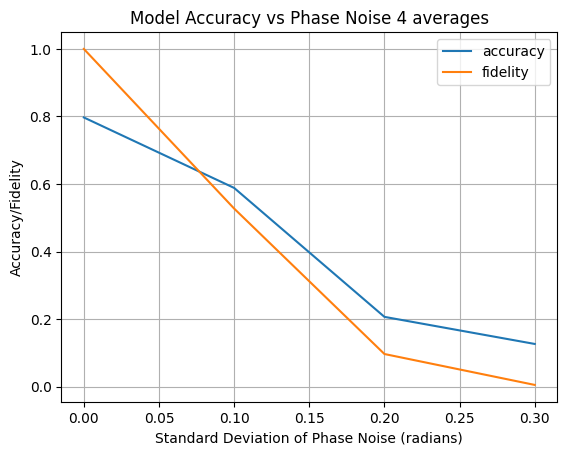

In [48]:
plt.plot(stdvs, accs, label="accuracy")
plt.plot(stdvs, fids, label="fidelity")
plt.xlabel("Standard Deviation of Phase Noise (radians)")
plt.ylabel("Accuracy/Fidelity")
plt.title(f"Model Accuracy vs Phase Noise 4 averages")
plt.grid(True)
plt.legend()
plt.show()

\[
U_2(0,0) = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
\]